In [3]:
from functions_git import *


Converting raster to numpy array...


100%|██████████████████████████████████████████████████████████████████████████████| 840/840 [00:00<00:00, 2295.07it/s]


######################### Amount Results #######################
SPEI-6 Payout Statistics 
Max Payout:  1152.27 
Minimum Payout:  32.21 
Median Payout:  210.93 
Mean Payout:  250.7 
Payout Standard Deviation:  144.65
######################### Results ##############################


<IPython.core.display.Javascript object>


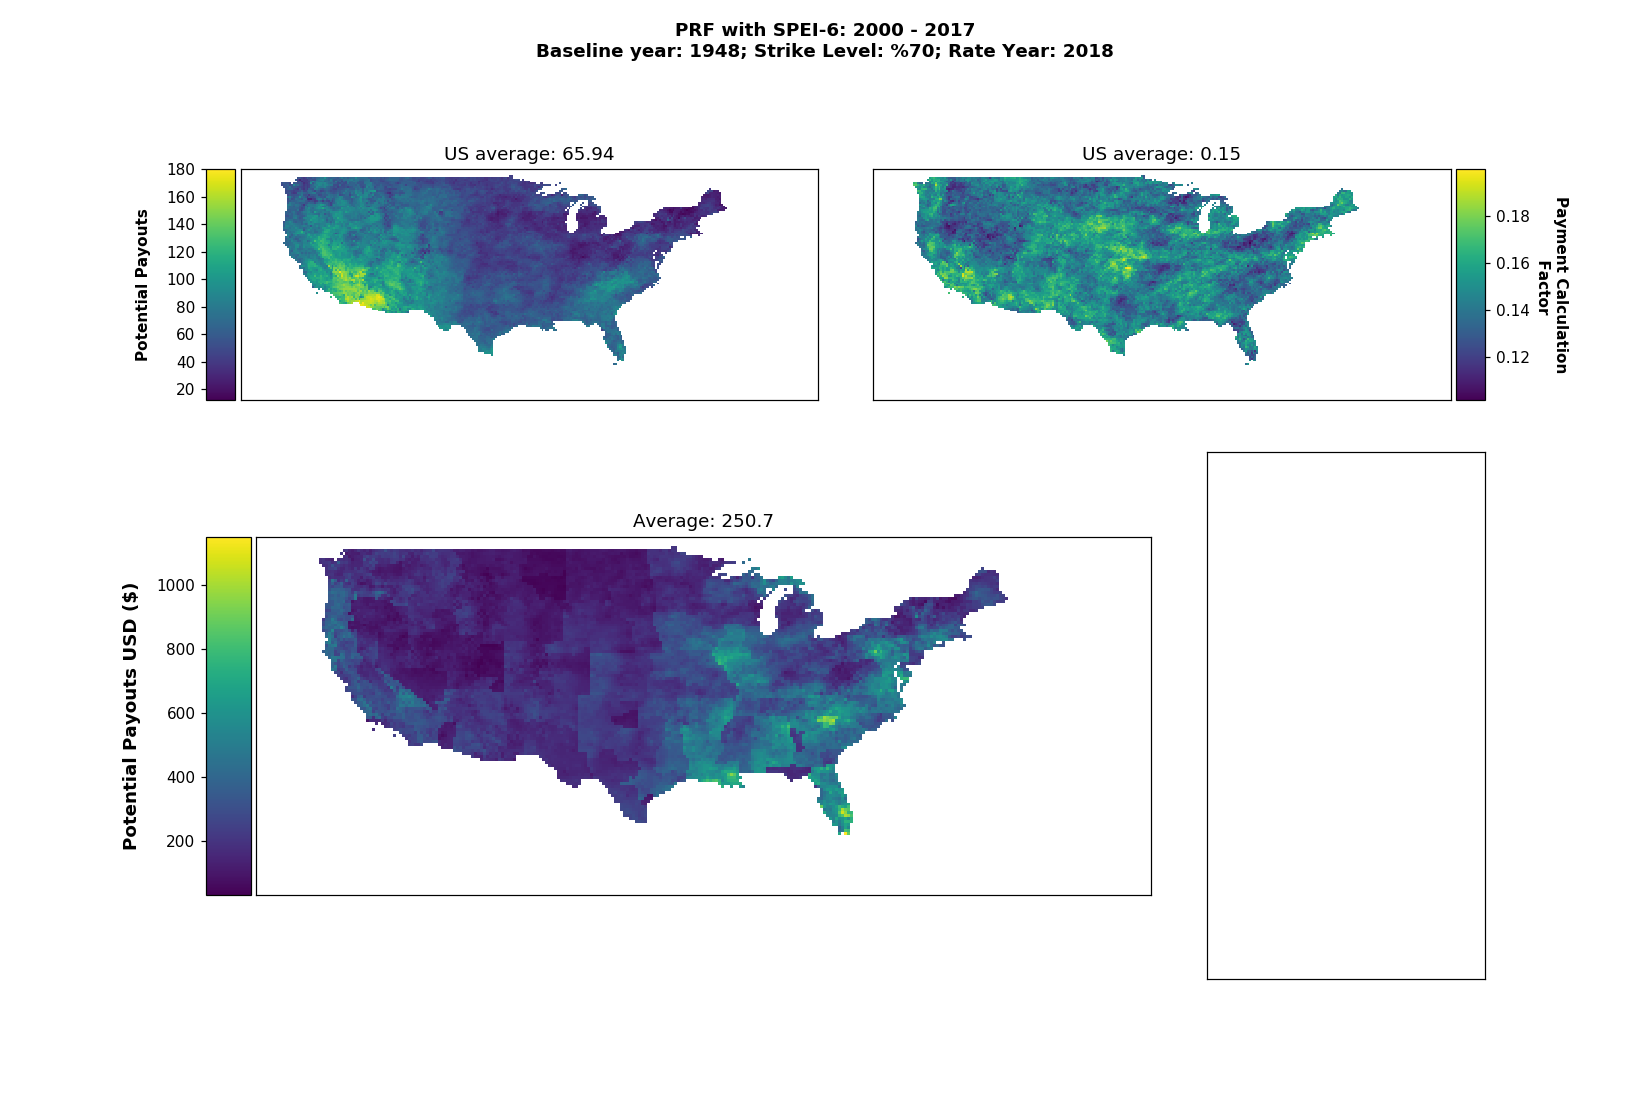

In [4]:
"""
Created on Fri Nov 17 22:19:03 2017

This script allows you to change parameters and call the functions. The working directory is set in the functions script while this is being tinkered with. 
    
    
*** To check rain-index outputs for accuracy set the baseline years from 1948 to 2016 and check the matching outputs from this site:
    
    https://prodwebnlb.rma.usda.gov/apps/prf#
    
@author: Travis
"""
%matplotlib notebook
mpld3.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

############################ Normal NOAA Method ###############################
#rasterpath = "e:\\data\\droughtindices\\noaa\\nad83\\raw"
##rasterpath = "f:\\data\\droughtindices\\noaa\\nad83\\raw"
#method = 1 # Method 1 is the present way of calculating triggers and magnitudes
#adjustit = False
#standardizeit = False
#indexit = True

####################### Test methods for drought indices ######################
#rasterpath = r'e:\data\droughtindices\palmer\pdsi\nad83'
rasterpath = r'd:\data\droughtindices\spei\nad83\6month'
#rasterpath = r'E:\data\droughtindices\grace\nad83\rz\monthly\quarteres'
method = 2 # method 2 set strike levels based on matching probability of occurrence with the RMA index
adjustit = True
standardizeit = True
indexit = False

############### Argument Definitions ##########################################
actuarialyear = 2018 
baselineyear = 1948
baselinendyear = 2016   
startyear = 2000
endyear = 2017
productivity = 1 
strike = .7
acres = 500
allocation = .5
difference = 0 # 0 = indemnities, 1 = net payouts, 2 = lossratios 


#################### Function Call #################################################################
[insurance_package_all, insurance_package_average, index_package_all,index_package,cid,coords] = indexInsurance(rasterpath, actuarialyear, startyear,endyear, baselineyear,baselinendyear, productivity, strike, acres, allocation, adjustit = adjustit,standardizeit = standardizeit, indexit = indexit, method = method, difference = difference) 

# Return order:
#insurance_package_all = [producerpremiums,indemnities]
#insurance_package_average = [meanppremium,meanindemnity]
#index_package_all = [frequencyrays,pcfrays]
#index_package = [frequencysum,meanpcf]